<a href="https://colab.research.google.com/github/TheBlondMyth/AlgoTrading/blob/main/NB2.1_Monitoring_training_validation_losses_and_configuration_of_optimiser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monitoring training/validation loss and configuration of optimiser


---

This notebook demonstrates how training and validation losses can be monitored during training. The underlying problem is based on NB 1.2 where we generate some noisy data from a given relationship
\begin{align}
y=f(x)=10x - x^2
\end{align}

In particular, the $N$ samples of data $(x^i,y^i)$ are obtained via:

1.   Create a list of $N$ feature values via $x^i:=10(i-1)/(N-1)$ for $i=1,...,N$ such that $x^i$'s are $N$ uniformly-spaced numbers in $[0,10]$.
2.   Generate values of the label $y^i$ via
\begin{align}
y^i=f(x^i)+\epsilon^i \qquad \text{for }i=1,...,N
\end{align}
where $\epsilon^i\sim N(0,\eta^2)$ are i.i.d. Gaussian random variables with mean zero and standard deviation $\eta$.

For the purpose of demonstration in this notebook, we will just consider a small number of sample $N=100$.

---



# Preparation of data and model setup

The procedures are the same as NB 1.2 and hence will not be further elaborated.

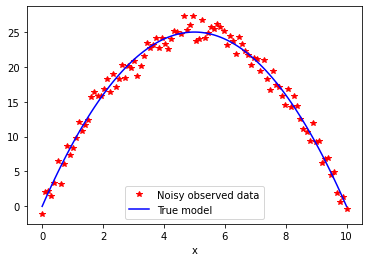

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

N = 100
eta = 1
np.random.seed(123)
tf.random.set_seed(123)

obs_x = np.linspace(0, 10, N)                 # create an array of N elements ranging from 0 to 10
true_y = 10*obs_x - obs_x**2
obs_y = true_y + np.random.normal(0, eta, N)       # add Gaussian noises to the label values

plt.plot(obs_x, obs_y, 'r*', label="Noisy observed data")
plt.plot(obs_x, true_y, 'b-', label="True model")
plt.xlabel('x')
plt.legend()

Our candidate model is a feedforward neural network with 4 hidden layers and each layer carries 100 neurons. ReLU activations are used at all hidden layers and the output activation is an identity function.

In [ ]:
MyModel = tf.keras.models.Sequential()
MyModel.add(tf.keras.layers.Dense(100, activation="relu", input_shape=(1,)))
for i in range(3):
    MyModel.add(tf.keras.layers.Dense(100, activation="relu"))
MyModel.add(tf.keras.layers.Dense(1, activation="linear"))

MyModel.summary()                           # show the model summary
MyModel.compile(loss="mean_squared_error") # compile the model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               200       
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 30,601
Trainable params: 30,601
Non-trainable params: 0
_________________________________________________________________


Finally, we split all the available data into the training and validation sets. We will do a 50-50 split using the function "train_test_split" from the "sklearn" library.

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(obs_x, obs_y, test_size=0.5, random_state=123) #fix the "random_state" to ensure same random split outcomes every time for reproducibility

# Training of the model with display of training and validation losses

The model can now be trained. If we want to compute both the training loss and validation loss over each epoch during training, this can be done within the "fit" function of TensorFlow. All we need to do is to supply the validation data to the "fit" function as well, and assign its output (an object) to a Python variable (we call this "MyModelResult").

We can also set the mini-batch size to be used during the training. If we do not supply any value, the default value used in TensorFlow is 32.

If you wish, you can also set verbose=1 which will then display all the training loss and validation loss values during the training. You can also simply drop "verbose=1" and the program by default will display the information.

Now let's train the model for 1000 epochs. (This will take a while to run)

In [ ]:
num_epochs = 1000

MyModelResult = MyModel.fit(x_train, y_train, epochs=num_epochs, batch_size=64, verbose=1, validation_data = (x_test, y_test))

Epoch 1/1000
1/1 [==============================] - 1s 1s/step - loss: 377.3542 - val_loss: 285.0992
Epoch 2/1000
1/1 [==============================] - 0s 27ms/step - loss: 346.4626 - val_loss: 266.1068
Epoch 3/1000
1/1 [==============================] - 0s 26ms/step - loss: 326.7784 - val_loss: 247.7880
Epoch 4/1000
1/1 [==============================] - 0s 25ms/step - loss: 307.6996 - val_loss: 228.6147
Epoch 5/1000
1/1 [==============================] - 0s 34ms/step - loss: 287.5798 - val_loss: 206.9424
Epoch 6/1000
1/1 [==============================] - 0s 33ms/step - loss: 264.6739 - val_loss: 183.7988
Epoch 7/1000
1/1 [==============================] - 0s 31ms/step - loss: 239.8832 - val_loss: 161.3895
Epoch 8/1000
1/1 [==============================] - 0s 31ms/step - loss: 215.4675 - val_loss: 141.3094
Epoch 9/1000
1/1 [==============================] - 0s 26ms/step - loss: 192.9736 - val_loss: 124.9923
Epoch 10/1000
1/1 [==============================] - 0s 30ms/step - loss: 1

The chunk of numbers displayed above refer to the training and validation losses obtained as we perform the "gradient descent style" iterations. Ideally, both numbers should be decreasing as more epoches are completed such that our algorithm is indeed trying to minimise the average losses.

We can now look inside the Python object "MyModelResult" and recover the training and validation loss values in each epoch. These are contained in a member of the object called "history". The training and validation losses are stored under the column named 'loss' and 'val_loss' respectively.

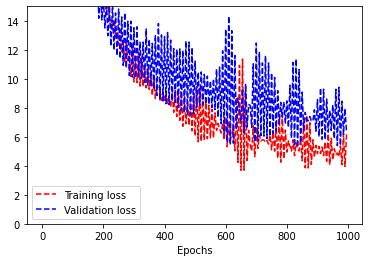

In [ ]:
my_train_loss = MyModelResult.history['loss']
my_val_loss   = MyModelResult.history['val_loss']


# The segment of code below is for plotting the results only
plot_interval = 5    # plot the result for every 5 epoch, else might be hard to read the plot
ep = range(num_epochs)
plt.plot(ep[::plot_interval], my_train_loss[::plot_interval], 'r--', label="Training loss")
plt.plot(ep[::plot_interval], my_val_loss[::plot_interval], 'b--', label="Validation loss")
plt.xlabel('Epochs')
plt.ylim(ymax = 15, ymin = 0)
plt.legend()

The training and validation losses are decreasing in general as training goes on. But we also see a lot of oscillations in the reported losses, which is usually a symptom that the learning rate may be too high or more generally the optimisation algorithm is not suitable for the current problem.

# Changing the default optimiser

In the TensorFlow library, the default optimiser used is "RMSProp". It is possible to change the type of the optimiser within the "compile" function.

Let us first define another neural network model which is identical to the one we used before, but we give it a different name "MyModel2".

In [ ]:
MyModel2 = tf.keras.models.Sequential()
MyModel2.add(tf.keras.layers.Dense(100, activation="relu", input_shape=(1,)))
for i in range(3):
    MyModel2.add(tf.keras.layers.Dense(100, activation="relu"))
MyModel2.add(tf.keras.layers.Dense(1, activation="linear"))

MyModel2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 100)               200       
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 100)               10100     
                                                                 
 dense_8 (Dense)             (None, 100)               10100     
                                                                 
 dense_9 (Dense)             (None, 1)                 101       
                                                                 
Total params: 30,601
Trainable params: 30,601
Non-trainable params: 0
_________________________________________________________________


Now we specify that the optimisation algorithm to be used is Adam. This can be easily done by the following line.

In [ ]:
MyModel2.compile(optimizer="adam", loss="mean_squared_error")

Then we perform the model fitting and output the training and validation losses over epochs, just like what we have done before.

Epoch 1/1000
1/1 [==============================] - 1s 576ms/step - loss: 362.6845 - val_loss: 293.9992
Epoch 2/1000
1/1 [==============================] - 0s 30ms/step - loss: 355.6760 - val_loss: 287.5310
Epoch 3/1000
1/1 [==============================] - 0s 26ms/step - loss: 348.9901 - val_loss: 281.5786
Epoch 4/1000
1/1 [==============================] - 0s 31ms/step - loss: 342.8310 - val_loss: 276.0596
Epoch 5/1000
1/1 [==============================] - 0s 27ms/step - loss: 337.1198 - val_loss: 270.3284
Epoch 6/1000
1/1 [==============================] - 0s 28ms/step - loss: 331.1682 - val_loss: 264.1296
Epoch 7/1000
1/1 [==============================] - 0s 35ms/step - loss: 324.7291 - val_loss: 257.4551
Epoch 8/1000
1/1 [==============================] - 0s 31ms/step - loss: 317.7749 - val_loss: 250.1896
Epoch 9/1000
1/1 [==============================] - 0s 35ms/step - loss: 310.1949 - val_loss: 242.4790
Epoch 10/1000
1/1 [==============================] - 0s 29ms/step - loss

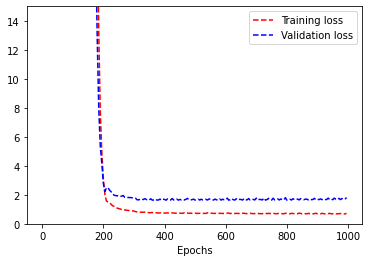

In [ ]:
MyModelResult2 = MyModel2.fit(x_train, y_train, epochs=num_epochs, batch_size=64, verbose=1, validation_data = (x_test, y_test))

my_train_loss2 = MyModelResult2.history['loss']
my_val_loss2   = MyModelResult2.history['val_loss']

plot_interval = 5
ep = range(num_epochs)
plt.plot(ep[::plot_interval], my_train_loss2[::plot_interval], 'r--', label="Training loss")
plt.plot(ep[::plot_interval], my_val_loss2[::plot_interval], 'b--', label="Validation loss")
plt.xlabel('Epochs')
plt.ylim(ymax = 15, ymin = 0)
plt.legend()

When we switch to Adam, the losses over epoch are now "smoother". The main reason is that the Adam algorithm has a momentum feature in the update rule with the gradient descent equation. The direction of update tends to be more stable over successive iterations and therefore there are less oscillations.

# Remark: possibility of overfitting

One thing to notice is that the validation loss is consistently higher than the training loss when number of epochs performed is above around 200. Beyond this point, further training does not help the model explain the data in the validation set (i.e. there is a risk of overfitting if we go beyond 200 epochs for this particular model and data set).